In [2]:
#import libs
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

All data collected from https://next-gen.materialsproject.org/

In [35]:
# Load features data
df = pd.read_csv('mp_ml_data_060624_no_lcons.csv')  # refer on how to collect data using Materials Projects API

In [4]:
# create function to calcuate R squared
def r2_score(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())
# ref: https://stackoverflow.com/questions/45250100/kerasregressor-coefficient-of-determination-r2-score

In [51]:
df.head()

,is_stable,is_gap_direct,is_metal,atom_1,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,...,atom_11,atom_12,atom_13,atom_14,atom_15,atom_16,atom_17,atom_18,atom_19,atom_20
0,True,False,False,66,83,83.0,53.0,8.0,8.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,True,False,False,19,19,30.0,9.0,9.0,9.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,True,False,False,55,32,17.0,17.0,17.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,True,False,False,89,26,8.0,8.0,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,True,True,False,59,59,1.0,1.0,34.0,34.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# drop unwanted columns, and yes i forgot to not save indexing columns
df.drop(columns=['formula_pretty','band_gap','volume','efermi','Unnamed: 0','density','mpids'],inplace=True)


In [39]:
df.head() # atom_n is the atomic number 

,is_stable,is_gap_direct,is_metal,atom_1,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,...,atom_11,atom_12,atom_13,atom_14,atom_15,atom_16,atom_17,atom_18,atom_19,atom_20
0,True,False,False,66,83,83.0,53.0,8.0,8.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,True,False,False,19,19,30.0,9.0,9.0,9.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,True,False,False,55,32,17.0,17.0,17.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,True,False,False,89,26,8.0,8.0,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,True,True,False,59,59,1.0,1.0,34.0,34.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# now do the same for target data
df_1 =  pd.read_csv('flattened_data_struct_filled.csv') 
df_1.drop(columns=['Unnamed: 0'],inplace=True)
df_1

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.000000,0.000000,0.000000,0.500000,0.500000,0.256559,0.500000,0.500000,0.743441,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.354788,0.354788,0.709575,0.645212,0.645212,0.290425,-0.000000,-0.000000,-0.000000,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.998403,0.998403,0.998403,0.515533,0.515533,0.515533,0.948638,0.496713,0.496713,0.496713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.000000,0.000000,0.000000,0.499999,0.499999,0.499999,0.499998,0.499999,0.999999,0.499998,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.666667,0.333333,0.750000,0.333333,0.666667,0.250000,0.666667,0.333333,0.250000,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,0.550646,0.550646,0.000000,0.000000,0.449354,0.666667,0.449354,0.000000,0.333333,0.304654,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
936,0.500000,0.500000,0.500000,-0.000000,-0.000000,0.000000,0.762162,0.762162,0.762162,0.237838,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
937,0.908143,0.908143,0.908143,0.500000,0.500000,0.500000,0.091857,0.091857,0.091857,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
938,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.333333,0.666667,0.250000,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df, df_1, test_size=0.05, random_state=0)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [18]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1])  # Output layer with number of outputs
])

# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',  # Loss function for regression
              metrics=['mae',r2_score])  # Mean Absolute Error and r2 as additional metric


c:\Users\AMMAR\anaconda3\envs\my-rdkit-env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
# start training 
history = model.fit(X_train, y_train, epochs=1200, batch_size=32, validation_split=0.1)

Epoch 1/1200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1499 - mae: 0.2285 - r2_score: -1.6139 - val_loss: 0.0704 - val_mae: 0.1709 - val_r2_score: -0.1743
Epoch 2/1200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0624 - mae: 0.1525 - r2_score: -0.1522 - val_loss: 0.0542 - val_mae: 0.1479 - val_r2_score: 0.0915
Epoch 3/1200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0455 - mae: 0.1344 - r2_score: 0.1254 - val_loss: 0.0456 - val_mae: 0.1364 - val_r2_score: 0.2339
Epoch 4/1200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0413 - mae: 0.1290 - r2_score: 0.2437 - val_loss: 0.0410 - val_mae: 0.1282 - val_r2_score: 0.3113
Epoch 5/1200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0364 - mae: 0.1209 - r2_score: 0.3194 - val_loss: 0.0378 - val_mae: 0.1231 - val_r2_score: 0.3636
Epoch 6/1200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0348 - mae: 0.1178 - r2_score: 0.3529 - val_loss: 0.0358 - val_mae: 0.1187 - val_r2_score: 0.3974
Epoch 7/1200
26/26 ━━━━━━━━━━━━━━━━━━

In [20]:

# Evaluate the model
test_loss, test_mae, test_r2 = model.evaluate(X_test, y_test)
print(f'Test MAE: {test_mae}')
print(f'Test R²: {test_r2}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0240 - mae: 0.0708 - r2_score: 0.5290 
Test MAE: 0.07065368443727493
Test R²: 0.5515192151069641


In [29]:
# save the model 
#model.save('saved_models/mp_tf_lnn_060624_r2_55.keras')
# make predictions
predictions = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [22]:
predictions[0]

array([-2.9501552e-02, -4.7381256e-02, -6.2525243e-02,  4.1723549e-01,
        3.6031568e-01,  4.1212922e-01,  5.2295536e-01,  6.1745155e-01,
        5.3759378e-01,  3.5399050e-01,  2.9725379e-01,  4.3558002e-01,
        7.9378039e-02,  4.9484909e-02,  1.0202276e-01,  3.3217162e-02,
       -5.1879466e-02,  1.0083902e-01, -1.3324082e-02,  1.1657804e-02,
       -6.8291426e-03,  5.9840448e-02,  8.5239694e-02,  6.1147094e-02,
        2.8831428e-02,  1.8508293e-02,  1.4741410e-02, -3.3381637e-03,
       -4.5667291e-03, -1.9623572e-03, -4.1040294e-03, -2.3959540e-03,
       -4.1825324e-03, -5.0040223e-03, -3.9880369e-03, -3.4234449e-03,
       -5.1076971e-03, -1.4502006e-03, -5.0831661e-03, -4.5667328e-03,
       -3.3381674e-03, -9.0686488e-04, -3.0611679e-03, -2.5332719e-03,
       -1.7950255e-03, -5.3005703e-03, -2.4293568e-03, -1.9618198e-03,
        2.8557262e-05, -1.1331635e-03, -2.2973847e-03, -1.1331644e-03,
        2.8890785e-05, -2.2973847e-03, -1.1331644e-03,  8.8562234e-04,
      

In [23]:
y_test.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
406,-0.000000,0.000000,-0.000000,0.500000,0.500000,0.500000,0.584367,0.584367,0.584367,0.415633,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.000000,0.000000,-0.000000,0.250000,0.250000,0.250000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
691,0.249999,0.249999,0.249999,0.749999,0.749999,0.749999,-0.000000,0.000000,-0.000000,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145,0.000000,0.000000,-0.000000,0.250000,0.250000,0.250000,0.272356,-0.002438,0.144967,-0.002438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
310,0.000000,0.000000,-0.000000,0.750000,0.750000,0.750000,0.250000,0.250000,0.250000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# slice depending on how many coordinate points you need  
y_test_slice = y_test.iloc[0, :30].values
predictions_slice = predictions[0, :30]

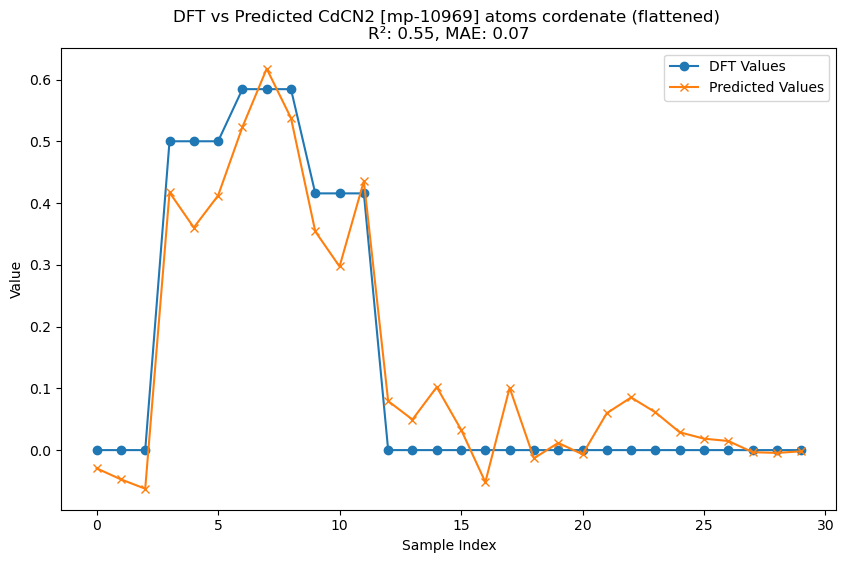

In [42]:
# plot actual and predeicted 
plt.figure(figsize=(10, 6))
plt.plot(y_test_slice, label='DFT Values', marker='o')
plt.plot(predictions_slice, label='Predicted Values', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title(f'DFT vs Predicted CdCN2 [mp-10969] atoms cordenate (flattened) \nR²: {test_r2:.2f}, MAE: {test_mae:.2f}')
plt.legend()
plt.show()

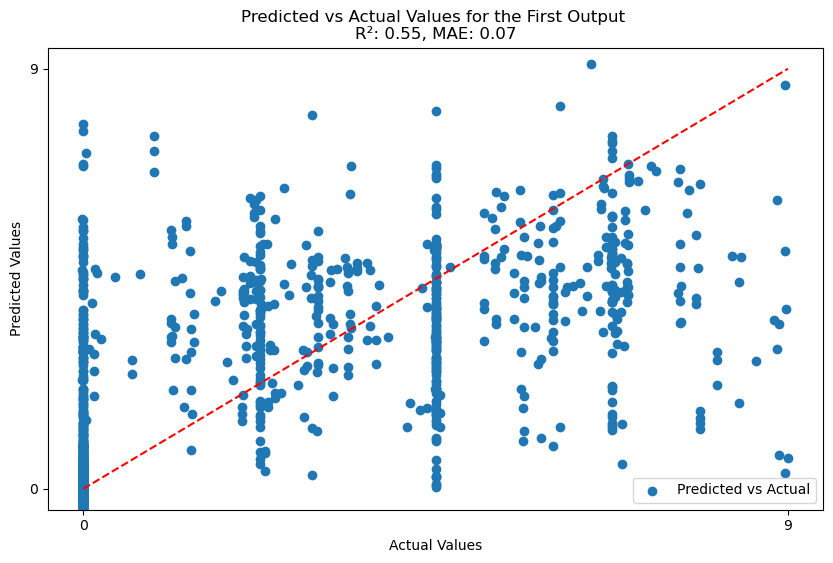

In [52]:
# such wierd plot 
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, label='Predicted vs Actual', marker='o')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Predicted vs Actual Values for the First Output \nR²: {test_r2:.2f}, MAE: {test_mae:.2f}')
plt.legend(loc='lower right')
plt.show()